### Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import cv2

import random
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skimage import filters

import warnings

from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras as tfk
from keras import layers as tfkl

from skimage.feature import hog
from skimage import io, color

warnings.filterwarnings('ignore')

### Seed

In [2]:
# seed fixed for reproducibility
seed = 69

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Loading Image Dataset

In [3]:
train_dir = 'Processed_dataset/train'
val_dir = 'Processed_dataset/val'
test_dir = 'Processed_dataset/test'

In [4]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3
batch_size = 8

In [5]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

training_set = datagen.flow_from_directory(
        directory = train_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

validation_set = datagen.flow_from_directory(
        directory = val_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = True
    )

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


In [6]:
train_size = len(training_set.classes)
val_size = len(validation_set.classes)
test_size = len(test_set.classes)

print('Training Set Size = ' + str(train_size))
print('Validation Set Size = ' + str(val_size))
print('Test Set Size = ' + str(test_size))

Training Set Size = 10834
Validation Set Size = 2327
Test Set Size = 2309


#### Visualization

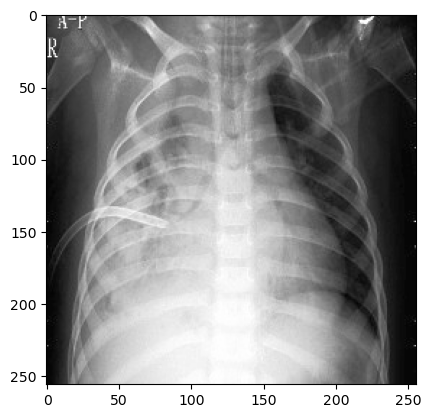

In [7]:
images, labels = training_set.next()


plt.imshow(np.uint8(images[0]),cmap = 'gray', vmin=0, vmax=255)
plt.show()

### Class Weights

In [8]:
from sklearn.utils import class_weight

train_labels = training_set.classes

class_weights = class_weight.compute_class_weight(class_weight = 'balanced', classes = np.unique(train_labels), y = train_labels)

class_weights = dict(zip(range(len(class_weights)), class_weights))
print(class_weights)


{0: 0.5520228268623255, 1: 1.211450296321145, 2: 2.754640223747775}


### HOG Features Extraction

In [9]:
orientations = 18
pixels_per_cell = (16, 16)
cells_per_block = (2, 2)

In [10]:
hog_features, hog_image = hog(images[0], orientations = orientations, 
                pixels_per_cell = pixels_per_cell, 
                cells_per_block = cells_per_block,
                multichannel = True,
                visualize = True)

In [11]:
hog_size = len(hog_features)
hog_size

16200

#### HOG Features Visualization

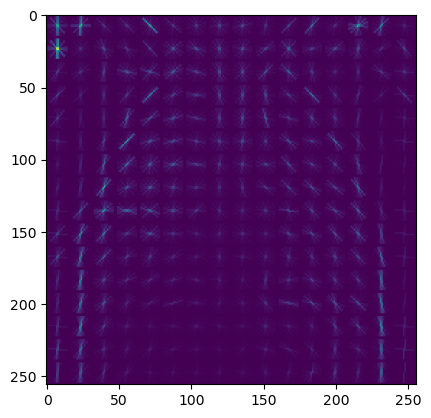

In [12]:
plt.imshow(hog_image)

In [13]:
def hog_features_generator(directory, batch_size, img_h, img_w, orientations, pixels_per_cell, cells_per_block):
    
    # Create an ImageDataGenerator object
    datagen = ImageDataGenerator()
    
    # Generate batches of images from a directory on disk
    generator = datagen.flow_from_directory(
        directory = directory,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = batch_size,
        shuffle = False
    )
    
    images, labels = generator.next()
    images = color.rgb2gray(images)
    
    hog_features = np.zeros((len(images), hog_size))
    
    for k in range(len(images)):
        hog_features[k, :] = hog(images[k], orientations = orientations, pixels_per_cell = pixels_per_cell, 
                        cells_per_block = cells_per_block, visualize = False)
        
    return hog_features, labels

In [14]:
train_hog, train_labels = hog_features_generator(train_dir, train_size, img_h, img_w, orientations, pixels_per_cell, cells_per_block)

val_hog, val_labels = hog_features_generator(val_dir, val_size, img_h, img_w, orientations, pixels_per_cell, cells_per_block)

test_hog, test_labels = hog_features_generator(test_dir, test_size, img_h, img_w, orientations, pixels_per_cell, cells_per_block)

Found 10834 images belonging to 3 classes.
Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


In [15]:
y_train = training_set.classes
y_val = validation_set.classes
y_test = test_set.classes

### Model

In [16]:
from sklearn.svm import SVC

svm_classifier = SVC(class_weight = class_weights, C = 0.7)

#### Training

In [17]:
svm_classifier.fit(train_hog, y_train)

SVC(C=0.7,
    class_weight={0: 0.5520228268623255, 1: 1.211450296321145,
                  2: 2.754640223747775})

### Prediction

In [18]:
def plot_confusionMatrix(true_labels, predicted_labels, classifier):
    cm = confusion_matrix(true_labels, predicted_labels, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap = 'Blues_r')
    plt.show()
    print(classification_report(true_labels, predicted_labels, target_names = ['N', 'P', 'T'], digits = 4))
    
    return 

#### Validation Set

In [19]:
val_predict = svm_classifier.predict(val_hog)

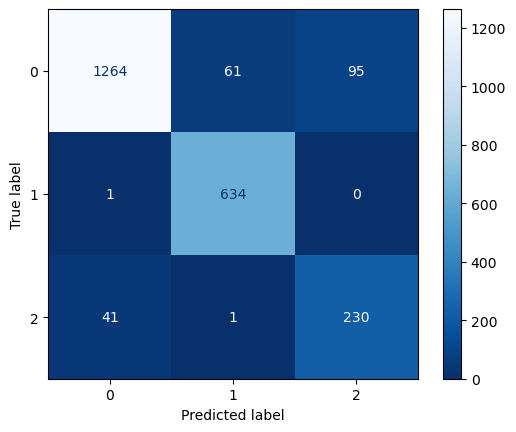

              precision    recall  f1-score   support

           N     0.9678    0.8901    0.9274      1420
           P     0.9109    0.9984    0.9527       635
           T     0.7077    0.8456    0.7705       272

    accuracy                         0.9145      2327
   macro avg     0.8622    0.9114    0.8835      2327
weighted avg     0.9219    0.9145    0.9159      2327



In [20]:
plot_confusionMatrix(validation_set.classes, val_predict, svm_classifier)

#### Test Set

In [21]:
test_predict = svm_classifier.predict(test_hog)

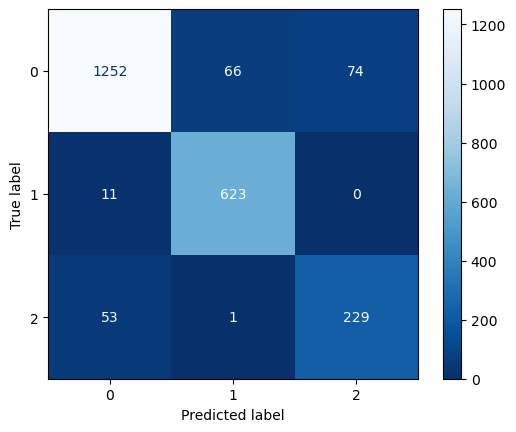

              precision    recall  f1-score   support

           N     0.9514    0.8994    0.9247      1392
           P     0.9029    0.9826    0.9411       634
           T     0.7558    0.8092    0.7816       283

    accuracy                         0.9112      2309
   macro avg     0.8700    0.8971    0.8824      2309
weighted avg     0.9141    0.9112    0.9116      2309



In [22]:
plot_confusionMatrix(test_set.classes, test_predict, svm_classifier)

### Save Model

In [38]:
from joblib import dump

dump(svm_classifier, 'SVM_Classifier_4.pkl')

['SVM_Classifier_4.pkl']